# Demo: Control of a wheel (showing the power of a state space model)

Import modules and configure the notebook.

In [1]:
# These are standard modules
import time
import numpy as np
import sympy as sym
from scipy.signal import place_poles
from scipy import linalg
import matplotlib.pyplot as plt

# This is a custom interface to the pybullet simulator
import ae353_wheel

pybullet build time: Oct 28 2022 16:21:09


#### Choose parameter values

The equation of motion is

$$c_1 \ddot{q} = \tau - c_1\sin q$$

where

* $q$ is the wheel angle
* $\tau$ is the wheel torque, i.e., the torque applied to the wheel by a motor on the ground

and where the values of $c_1$ and $c_2$ are given as follows:

In [2]:
# Values of c1 and c2 for the example (do not change)
c1 = 1.0
c2 = 2.0

# Values of other parameters that are given
g = 9.81 # <-- acceleration of gravity
r = 0.35 # <-- distance from wheel axis to marker (i.e., to the mass)

# Values of other parameters that correspond to the coefficients c1 and c2 that we chose
m = c2 / (g * r)   # <-- set in code
J = c1 - m * r**2  # <-- set in URDF
print(f'm = {m}\nJ = {J}')

m = 0.582495995340032
J = 0.928644240570846


#### Find state space model

Define symbolic variables:

In [3]:
q, v, tau = sym.symbols('q, v, tau')

Define ODEs:

In [4]:
f = sym.Matrix([
    v,
    (tau - c2 * sym.sin(q)) / c1,
])

Convert floats to rationals:

In [5]:
f = sym.nsimplify(f, rational=True)

See the result:

In [6]:
f

Matrix([
[             v],
[tau - 2*sin(q)]])

Choose equilibrium point:

In [7]:
q_e = np.pi
v_e = 0.
tau_e = 0.

Linearize:

In [8]:
A_num = sym.lambdify([q, v, tau], f.jacobian([q, v]))
A = A_num(q_e, v_e, tau_e).astype(float)
print(f'A =\n{A}')

print('')

B_num = sym.lambdify([q, v, tau], f.jacobian([tau]))
B = B_num(q_e, v_e, tau_e).astype(float)
print(f'B =\n{B}')

A =
[[0. 1.]
 [2. 0.]]

B =
[[0.]
 [1.]]


The state-space model is

$$\dot{x} = Ax+Bu$$

with $A$ and $B$ computed as above and with the state and input defined as

$$x = \begin{bmatrix} q - q_e \\ v - v_e \end{bmatrix} \qquad\qquad u = \begin{bmatrix} \tau - \tau_e \end{bmatrix}.$$

#### Do simulations

Create an instance of the `Simulator` class with particular values of `roll` and `mass`.

In [9]:
simulator = ae353_wheel.Simulator(
    display=True,
    roll=(np.pi / 2),
    mass=m,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


Define a function to plot results.

In [10]:
def show_results(
        data,
        qe, ve, taue,
        x1_num=None, x2_num=None, u1_num=None,
        q_num=None, v_num=None, tau_num=None,
    ):
    
    t = data['t']
    q = data['wheel_angle']
    v = data['wheel_velocity']
    tau = data['wheel_torque']
    tau_cmd = data['wheel_torque_command']
    x1 = q - qe
    x2 = v - ve
    u1 = tau - taue
    u1_cmd = tau_cmd - taue
    
    fig, ((ax_q, ax_x1), (ax_v, ax_x2), (ax_tau, ax_u1)) = plt.subplots(
        3, 2, figsize=(15, 10), sharex=True,
    )

    ax_q.plot(t, q, label='$q$', linewidth=4)
    ax_q.plot(t, np.ones_like(t) * qe, '--', label='$q_e$', linewidth=4)
    
    ax_v.plot(t, v, label='$v$', linewidth=4)
    ax_v.plot(t, np.ones_like(t) * ve, '--', label='$v_e$', linewidth=4)
    
    ax_tau.plot(t, tau, label=r'$\tau$', linewidth=4)
    ax_tau.plot(t, np.ones_like(t) * taue, '--', label=r'$\tau_e$', linewidth=4)
    
    ax_x1.plot(t, x1, label='$x_1$', linewidth=4)
    ax_x2.plot(t, x2, label='$x_2$', linewidth=4)
    ax_u1.plot(t, u1, label='$u_1$', linewidth=4)
    
    ax_tau.plot(t, tau_cmd, '-.', label=r'$\tau$ (command)', linewidth=3, color='C6')
    ax_u1.plot(t, u1_cmd, '-.', label='$u_1$ (command)', linewidth=3, color='C6')
    
    if q_num is not None: # <-- should really check if all *_num are not None!
        ax_q.plot(t, q_num, ':', label='$q$ (linear)', linewidth=6, color='C3')
        ax_v.plot(t, v_num, ':', label='$v$ (linear)', linewidth=6, color='C3')
        ax_tau.plot(t, tau_num, ':', label=r'$\tau$ (linear)', linewidth=6, color='C3')
        ax_x1.plot(t, x1_num, ':', label='$x_1$ (linear)', linewidth=6, color='C3')
        ax_x2.plot(t, x2_num, ':', label='$x_2$ (linear)', linewidth=6, color='C3')
        ax_u1.plot(t, u1_num, ':', label='$u_1$ (linear)', linewidth=6, color='C3')
    
    tau_max = np.ones_like(t) * simulator.tau_max
    ax_tau.plot(t, tau_max, '--', label=r'$\tau$ (max)', linewidth=2, color='C2', zorder=0)
    ax_tau.plot(t, - tau_max, '--', linewidth=2, color='C2', zorder=0)
    ax_u1.plot(t, tau_max - tau_e, '--', label=r'$u_1$ (max)', linewidth=2, color='C2', zorder=0)
    ax_u1.plot(t, - tau_max - tau_e, '--', linewidth=2, color='C2', zorder=0)
            
    ax_q.grid()
    ax_q.legend(fontsize=16)
    ax_q.tick_params(labelsize=14)
    ax_q.set_ylim(np.pi - 0.25, np.pi + 0.25)
    
    ax_v.grid()
    ax_v.legend(fontsize=16)
    ax_v.tick_params(labelsize=14)
    ax_v.set_ylim(-1, 1)
    
    ax_tau.grid()
    ax_tau.legend(fontsize=16, loc='upper right')
    ax_tau.tick_params(labelsize=14)
    ax_tau.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

    ax_x1.grid()
    ax_x1.legend(fontsize=16)
    ax_x1.tick_params(labelsize=14)
    ax_x1.set_ylim(-0.25, 0.25)
        
    ax_x2.grid()
    ax_x2.legend(fontsize=16)
    ax_x2.tick_params(labelsize=14)
    ax_x2.set_ylim(-1, 1)
    
    ax_u1.grid()
    ax_u1.legend(fontsize=16, loc='upper right')
    ax_u1.tick_params(labelsize=14)
    ax_u1.set_ylim(taue + -1.2 * simulator.tau_max, taue + 1.2 * simulator.tau_max)
    
    ax_tau.set_xlabel('time (s)', fontsize=20)
    ax_tau.set_xlim([data['t'][0], data['t'][-1]])
    ax_u1.set_xlabel('time (s)', fontsize=20)
    ax_u1.set_xlim([data['t'][0], data['t'][-1]])
    
    fig.tight_layout()
    plt.show()

Define a controller that maps sensor measurements (`wheel_angle` and `wheel_velocity`) to actuator commands (`wheel_torque`). By default, it chooses to apply zero torque to the wheel. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [11]:
class Controller:
    def __init__(self, K, q_e, v_e, tau_e):
        self.K = K
        self.q_e = q_e
        self.v_e = v_e
        self.tau_e = tau_e
    
    def reset(self):
        pass
    
    def run(self, t, wheel_angle, wheel_velocity):
        """
        INPUTS
         t = current time (s)
         wheel_angle = angle of wheel (rad)
         wheel_velocity = angular of wheel (rad / s)
        
        OUTPUTS
         wheel_torque = torque applied to wheel by motor on ground (N m)
        """
        
        # FIXME: replace the following line
        x = np.array([
            wheel_angle - self.q_e,
            wheel_velocity - self.v_e,
        ])
        u = - self.K @ x
        wheel_torque = u[0] + self.tau_e
        
        return wheel_torque

Choose gain matrix.

In [23]:
# K = np.array([[8., 5.]])

K = np.array([[28., 2.]])
# K = np.array([[-4., 1.]])
# K = np.array([[3., 2.]])
# K = np.array([[1., 1.]])

Create an instance of the controller.

In [24]:
controller = Controller(K, q_e, v_e, tau_e)

Choose initial conditions.

In [25]:
q_i = np.pi - 0.2
v_i = 0.

Reset the simulator. Optional arguments allow you to specify the initial wheel angle and velocity. If the value of either argument is `None` (or if the argument is left unspecified), then its value will be chosen at random.

In [26]:
simulator.reset(
    wheel_angle=q_i,
    wheel_velocity=v_i,
)

Reset the controller.

In [27]:
controller.reset()

Run the simulator.

In [28]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=5.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

Plot the results.

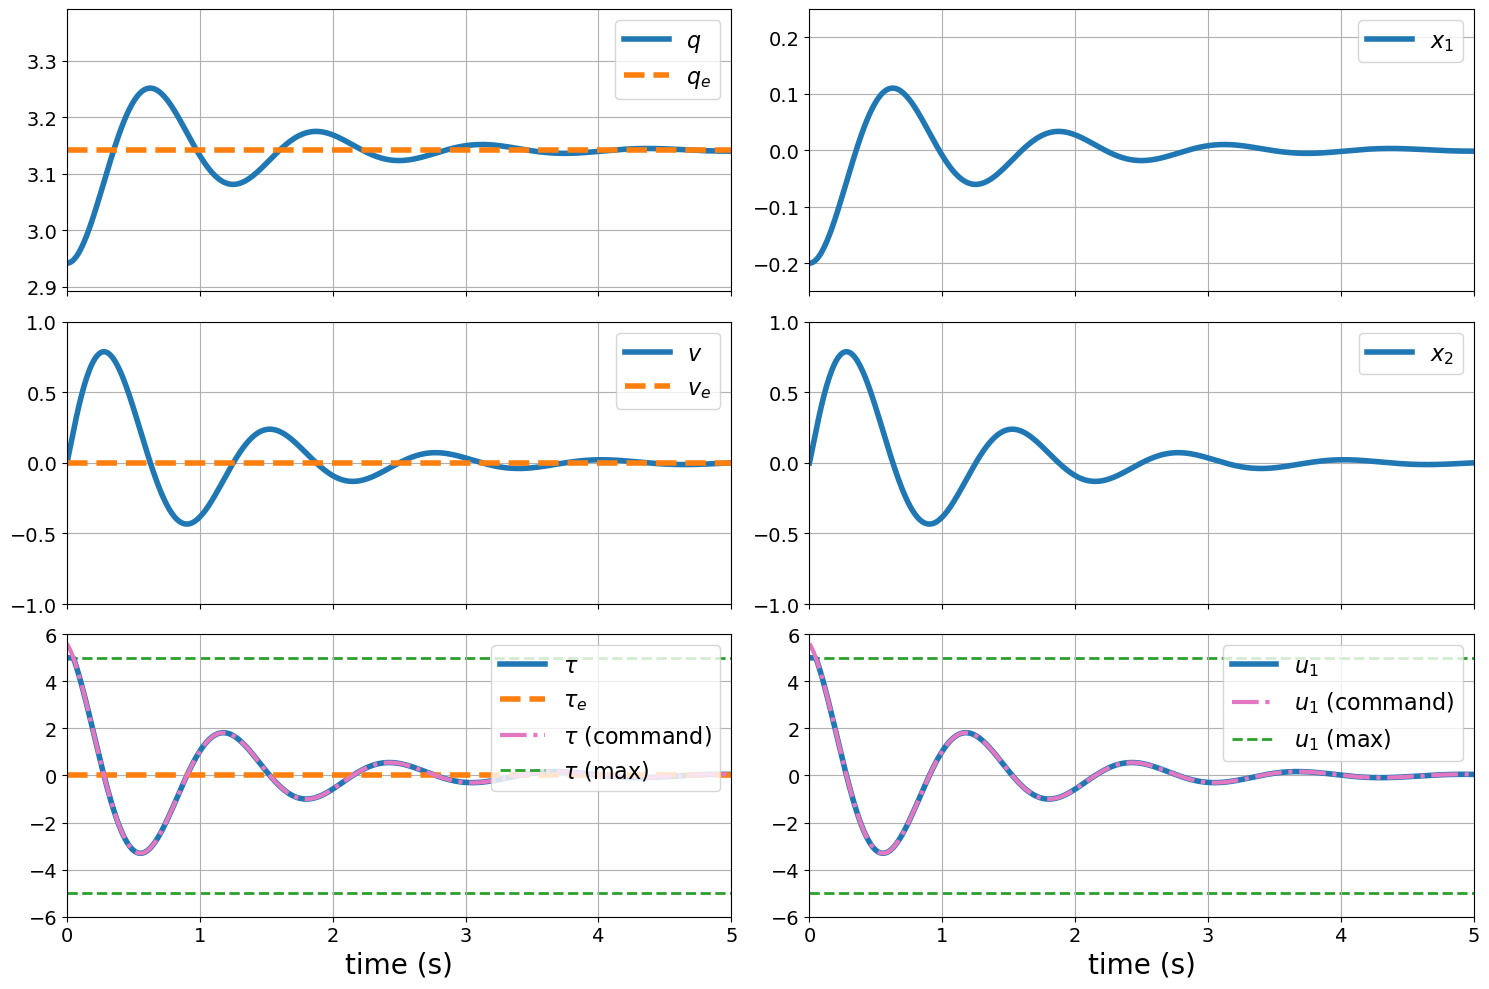

In [29]:
show_results(
    data,                       # <-- data from simulation
    q_e, v_e, tau_e,            # <-- equilibrium point
)

The solution to

$$\dot{x} = (A - BK) x$$

is

$$x(t) = e^{(A - BK) t}x(0)$$

where $e^{(\cdots)}$ is the **matrix** exponential function. Here is how to find $x(t)$ at a given time $t$ with numeric computation:

In [30]:
# Choose a time at which to find the solution
t = 0.5

# Define initial conditions
x0 = np.array([
    q_i - q_e,
    v_i - v_e,
])

# Find the solution using the matrix exponential function
print(linalg.expm((A - B @ K) * t) @ x0)

[0.08266396 0.37751137]


Here is how to find $x(t)$ at an array of times $[0, \Delta t, 2\Delta t, \ldots]$ with numeric computation:

In [31]:
# Define initial conditions
x0 = np.array([
    q_i - q_e,
    v_i - v_e,
])

# Create empty arrays to hold state and input at each time
x = []
u = []

# Compute (linear) state and input at each time
for t in data['t']:
    xt = linalg.expm((A - B @ K) * t) @ x0
    ut = - K @ xt
    x.append(xt)
    u.append(ut)
x = np.array(x)
u = np.array(u)

# Get components of x(t) and u(t)
x1_num = x[:, 0]
x2_num = x[:, 1]
u1_num = u[:, 0]

# Compute q(t), v(t), and tau(t) from x1(t), x2(t), and u1(t)
q_num = x1_num + q_e
v_num = x2_num + v_e
tau_num = u1_num + tau_e

Plot the results again, this time comparing what we get from simulation to what we get from solving the closed-loop linear system.

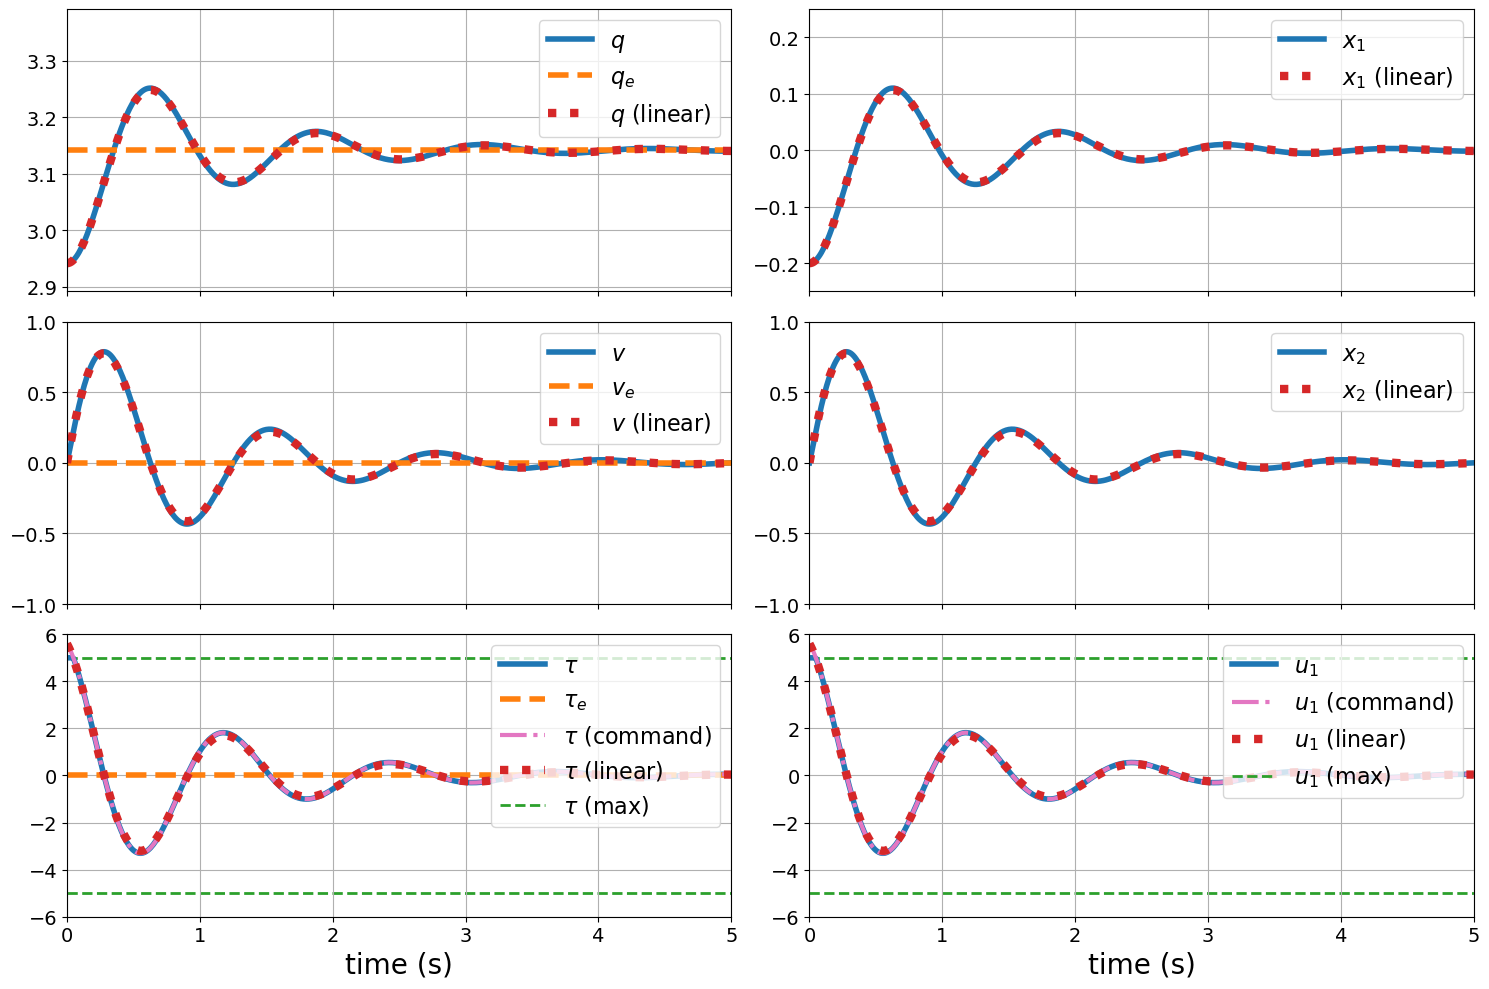

In [32]:
show_results(
    data,                       # <-- data from simulation
    q_e, v_e, tau_e,            # <-- equilibrium point
    x1_num, x2_num, u1_num,     # <-- solution to (closed-loop) linear system
    q_num, v_num, tau_num,      # <-- equivalent, approximate solution to (closed-loop) nonlinear system
)

Solve for $x(t)$ again, this time with symbolic computation instead of numeric computation:

In [33]:
# Model
A_sym = sym.nsimplify(sym.Matrix(A), rational=True)
B_sym = sym.nsimplify(sym.Matrix(B), rational=True)
K_sym = sym.nsimplify(sym.Matrix(K), rational=True)

# Variables
t = sym.symbols('t', real=True)

# Initial condition
x0 = sym.nsimplify(sym.Matrix([q_i - q_e, v_i - v_e]), rational=True)

# Solution
x_sym = sym.exp((A_sym - B_sym @ K_sym) * t) @ x0

# Show the solution
display(x_sym)

Matrix([
[-exp(-t)*sin(5*t)/25 - exp(-t)*cos(5*t)/5],
[                   26*exp(-t)*sin(5*t)/25]])

Find the eigenvalues of $A - BK$.

In [34]:
print(linalg.eigvals(A - B @ K))

[-1.+5.j -1.-5.j]
